In [5]:
import pickle 

with open("../dataset/dorsal_stream_dataset.pickle", "rb") as f:
    dataset = pickle.load(f)

with open("../dataset/dorsal_stream_neuron_table.pickle", "rb") as f:
    neuron_table = pickle.load(f)

/tmp/ipykernel_1243465/621977434.py:64: RuntimeWarning: invalid value encountered in scalar divide
  cmod_val = (np.max(row['rf_norm']) - np.nanmean(row['rf_norm']))/(np.max(row['rf_norm']) + np.nanmean(row['rf_norm']))
/tmp/ipykernel_1243465/621977434.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


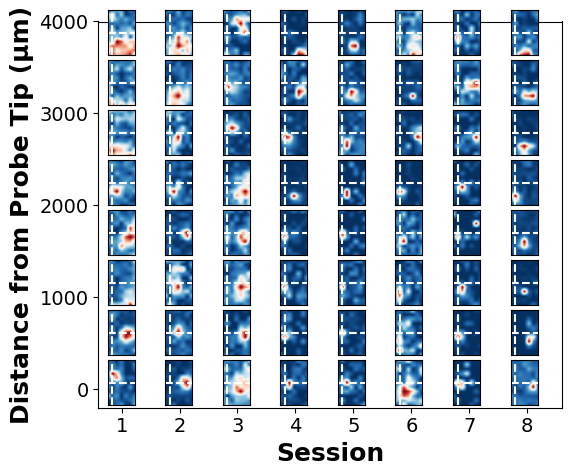

In [21]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def interpolate_rf(rf):
    y_range = np.arange(-15, 18, 3)
    x_range = np.arange(-3, 18, 3)
    interp = RegularGridInterpolator((y_range, x_range), rf.T)

    new_width = 180
    new_height = 300
    x = np.linspace(-3, 15, new_width)
    y = np.linspace(-15, 15, new_height)
    xg, yg = np.meshgrid(x, y)
    new_rf = interp(np.vstack((yg.ravel(), xg.ravel())).T)
    new_rf = new_rf.reshape((new_height, new_width))
    return new_rf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
# Assume df is your dataframe
def plot_waveforms_along_probe(df):
    # Only necessary columns
    df = df[['session_id', 'x_coord_neu', 'y_coord_neu', 'rf', 'rf_norm', 'x_coord_rf', 'y_coord_rf']]

    # Sort sessions in order of appearance
    session_order = df['session_id'].drop_duplicates().tolist()
    session_leg = [i + 1 for i in range(len(df['session_id'].drop_duplicates().tolist()))]
    session_to_xbase = {sess: i * 100 for i, sess in enumerate(session_order)}  # 150 um spacing between sessions

    # Color mapping for spike types (pastel colors)
    color_map = {'FS': '#77DD77', 'RS': '#FFB347', 'AS': '#d6e2e7'}
    legend_labels = {'FS': 'Fast-Spiking (FS)', 'RS': 'Regular-Spiking (RS)', 'AS': 'Axonal-Spiking (AS)'}
    legend_handles = {}

    fig, ax = plt.subplots(figsize=(6,5))#(8, 6))
    cnt = 0
    ses_cnt = 0
    prev_sess_id = None

    for ses_cnt, sess_id in enumerate(session_order):
        sess_df = df[df['session_id'] == sess_id]
        x_base = session_to_xbase[sess_id]

        for y_start in range(0, 4000, 500):
            y_end = y_start + 500
            bin_df = sess_df[(sess_df['y_coord_neu'] >= y_start) & (sess_df['y_coord_neu'] < y_end)]


            fr_crit = 10
            best_row = 0
            while best_row == 0:
                max_val = 0
                mod_val = 0
                best_row = 0
                fr_crit = fr_crit - 1
                for idx, row in bin_df.iterrows():
                    cmod_val = (np.max(row['rf_norm']) - np.nanmean(row['rf_norm']))/(np.max(row['rf_norm']) + np.nanmean(row['rf_norm']))
                    r, c = np.unravel_index(np.argmax(row['rf']), row['rf'].shape)
                    rf2 = deepcopy(row['rf'])
                    rf2[r,c] = 0
                    r1, c1 = np.unravel_index(np.argmax(rf2), rf2.shape)
    
                    if np.max(row['rf'])*1000 > fr_crit and cmod_val > max_val and np.sqrt(((r-r1) ** 2 + (c-c1) ** 2)) < 20 and row['x_coord_rf'] >= 0 and row['x_coord_rf'] <= 12 and row['y_coord_rf'] <= 12: # and cmod_val > 0.4:
                        mod_val = cmod_val
                        max_val = cmod_val
                        best_row = idx
                if fr_crit < 0:
                    raise ValueError()
            row = bin_df.loc[best_row]

            plt.figure(fig.number)
            plt.sca(ax)
            sess_id = row['session_id']
                    
            x_base = session_to_xbase[sess_id] 
            
            inset2 = fig.add_axes([0.18 + 0.096*(ses_cnt), .17 + y_start/5000, .09, .09])
            inset2.imshow(interpolate_rf(row['rf_norm']), cmap='RdBu_r')
            inset2.axvline(30, linestyle='--', c='white')
            inset2.axhline(150, linestyle='--', c='white')
            plt.setp(inset2, xticks=[], yticks=[])
    plt.sca(ax)
    plt.xlabel('Session', fontsize=18, fontweight='bold')
    plt.ylabel('Distance from Probe Tip (µm)',fontsize=18, fontweight='bold')

    # Session labels on x-axis
    x_ticks = list(session_to_xbase.values())
    x_ticks = np.arange(8)/8
    plt.xticks(x_ticks, session_leg, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(-.05, .95)
    plt.ylim(-200, 4000)

    ordered_types = ['AS', 'FS', 'RS']
    plt.tight_layout()
    plt.savefig("figures/rfs.pdf")
    plt.show()

plot_waveforms_along_probe(neuron_table)

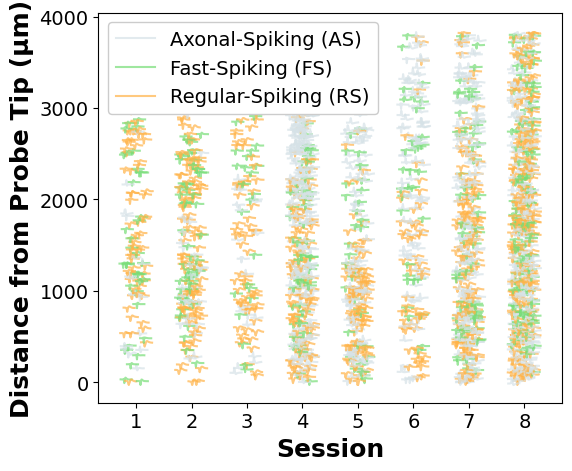

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
color_map = {'FS': '#77DD77', 'RS': '#FFB347', 'AS': '#d6e2e7'}

# Assume df is your dataframe
def plot_waveforms_along_probe(df):
    # Only necessary columns
    df = df[['session_id', 'x_coord_neu', 'y_coord_neu', 'template', 'template_type']]

    # Sort sessions in order of appearance
    session_order = df['session_id'].drop_duplicates().tolist()
    session_leg = [i + 1 for i in range(len(df['session_id'].drop_duplicates().tolist()))]
    session_to_xbase = {sess: i * 100 for i, sess in enumerate(session_order)}  # 150 um spacing between sessions

    # Color mapping for spike types (pastel colors)
    color_map = {'FS': '#77DD77', 'RS': '#FFB347', 'AS': '#d6e2e7'}
    legend_labels = {'FS': 'Fast-Spiking (FS)', 'RS': 'Regular-Spiking (RS)', 'AS': 'Axonal-Spiking (AS)'}
    legend_handles = {}

    plt.figure(figsize=(6,5))#(8, 6))

    for idx, row in df.iterrows():
        sess_id = row['session_id']
        y = row['y_coord_neu']  # in microns
        waveform = np.array(row['template'])
        spike_type = row['template_type']

        # Normalize waveform from 0 to 1
        waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min() + 1e-6)
        # Scale to 30 microns height and center vertically at y_coord_neu
        waveform_scaled = (waveform - 0.5) * 60 + y

        # Horizontal base position + jitter
        x_base = session_to_xbase[sess_id] + np.random.uniform(-20, 20)
        x_waveform = np.linspace(-10, 10, len(waveform)) + x_base

        color = color_map.get(spike_type, 'gray')
        line, = plt.plot(x_waveform, waveform_scaled, color=color, alpha=0.7, label=legend_labels.get(spike_type, spike_type))

        if spike_type not in legend_handles:
            legend_handles[spike_type] = line

    plt.xlabel('Session', fontsize=18, fontweight='bold')
    plt.ylabel('Distance from Probe Tip (µm)',fontsize=18, fontweight='bold')

    # Session labels on x-axis
    x_ticks = list(session_to_xbase.values())
    plt.xticks(x_ticks, session_leg, fontsize=14)
    plt.yticks(fontsize=14)

    ordered_types = ['AS', 'FS', 'RS']
    plt.legend(handles=[legend_handles[stype] for stype in ordered_types if stype in legend_handles], 
               labels=[legend_labels[stype] for stype in ordered_types if stype in legend_handles],
                 loc='upper left', framealpha = 1, fontsize=14)
    plt.tight_layout()
    plt.savefig("figures/templates.pdf")
    plt.show()

plot_waveforms_along_probe(neuron_table)

110
19    [-5  0]
Name: fix_coord_deg, dtype: object


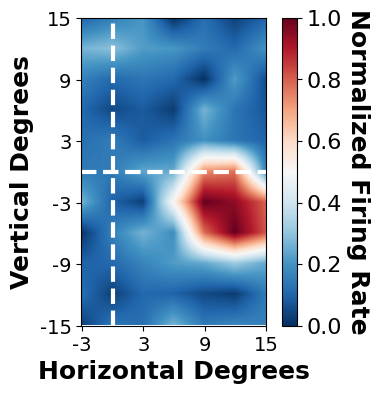

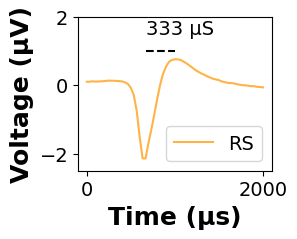

In [4]:
# plot 1 example receptive field 
# GET EXAMPLE RFS for two neurons & example learned feature map coordinates 
import matplotlib 
from scipy.interpolate import  RegularGridInterpolator
from scipy.signal import convolve2d

def interpolate_rf(rf):
    y_range = np.arange(-15, 18, 3)
    x_range = np.arange(-3, 18, 3)
    
    interp = RegularGridInterpolator((x_range, y_range), rf)
    new_width = 180
    new_height = 300
    x = np.linspace(-3, 15, new_width)
    y = np.linspace(-15, 15, new_height)
    xg, yg = np.meshgrid(x, y)
    xg, yg = np.reshape(xg, -1), np.reshape(yg, -1)

    new_rf = interp(np.hstack((xg[:, None], yg[:, None])))

    new_rf = np.reshape(new_rf, (new_height, new_width)).T
    return new_rf



neuron_id = 110
session_mask = np.logical_and(neuron_table['session_id'] == 82824, neuron_table['neuron_id'] == neuron_id)

for i in range(1):
    if np.sum(session_mask) > 0:
        print(neuron_id)
        norm_rf = interpolate_rf(neuron_table.loc[session_mask]['rf_norm'].T.item())
        
        font = {'family' : 'sans',
                'weight' : 'normal',
                'size'   : 16}

        plt.figure(figsize=(4, 4))
        matplotlib.rc('font', **font)
        print(neuron_table.loc[session_mask]['fix_coord_deg'])
        plt.imshow(norm_rf.T, cmap='RdBu_r')
        plt.xticks(np.array([0, 2, 4, 6])*30, labels=[-3, 3, 9, 15], fontsize=14)
        plt.yticks(np.array([0, 2, 4, 6, 8, 10])*30, labels=[15, 9, 3, -3, -9, -15], fontsize=14)
        
        plt.xlabel("Horizontal Degrees", fontweight='bold', fontsize=18)
        plt.ylabel("Vertical Degrees", fontweight='bold', fontsize=18)    
        cbar = plt.colorbar(label="Normalized Firing Rate")
        cbar.set_label(label='Normalized Firing Rate',weight='bold', rotation=-90, labelpad=20, fontsize=18)
        plt.axvline(30, linestyle='--', c='white', linewidth=3)
        plt.axhline(150, linestyle='--', c='white', linewidth=3)
        plt.clim([0,1])
        plt.savefig("figures/example_rf.pdf",  bbox_inches='tight')
        plt.show()
        

# plot example template for this neuron
plt.figure(figsize=(2.5, 2))
template_times = 1000*np.array(neuron_table.loc[session_mask]['template_times'].item())
template = np.array(neuron_table.loc[session_mask]['template'].item())
plt.plot(template_times, template, c=color_map[neuron_table.loc[session_mask]['template_type'].item()])
plt.legend(["RS"], fontsize=14)
plt.xlabel("Time (µs)", fontweight='bold', fontsize=18)
plt.ylabel("Voltage (µV)", fontweight='bold', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
times = np.array([template_times[np.argmin(template)], template_times[np.argmax(template)]])
plt.plot(times, [1, 1], linestyle='--', color='k')
plt.text(times[0], 1.5, str(int(np.around(times[1]-times[0]))) + " µS", fontsize=14)
plt.ylim([-2.5, 2])
plt.savefig("figures/example_waveform.pdf",  bbox_inches='tight')
plt.show()